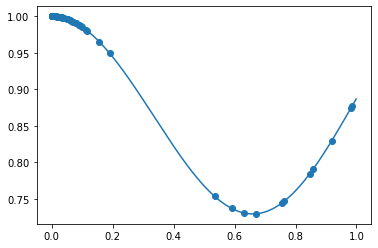

Best Result: x=0.000, y=1.000


In [51]:
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor
from math import sin
from math import cos
from math import pi
from numpy import arange
from numpy import asarray
from numpy import argmax
from numpy import vstack
from numpy.random import normal
from numpy.random import random
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
# must create custom gaussian process

# objective function
def objective(x, n=0.1):
#     noise = normal(loc=0, scale=n)
    return sin(x**2)+cos(x)**5

class baysian_optimize():
    
    def __init__(self, objective, Range, n_iter = 50, epsilon = 0.1):
        self.objective = objective
        self.iterations = n_iter
        self.Range = Range
        self.decay = 1/(n_iter)
        self.epsilon = epsilon

    # surrogate or approximation for the objective function


    def surrogate(self, model, X):
        # catch any warning generated when making a prediction
        with catch_warnings():
            # ignore generated warnings
            simplefilter("ignore")
            return model.predict(X, return_std=True)

    # probability of improvement acquisition function


    def acquisition(self, X, samples, model):
        # 	# calculate the best surrogate score found so far
        mean, std = self.approximation(model, samples)
        mean = mean[:, 0]
        scores, _ = self.approximation(model, X)
        x_plus = max(scores)
        PI = norm.cdf((mean - x_plus - self.epsilon) / (std+1E-9))
        return PI

    # plot real observations vs surrogate function


    def plot(self, X, y, model):
        # scatter plot of inputs and real objective function
        pyplot.scatter(X, y)
        # line plot of surrogate function across domain
        Xsamples = asarray(arange(0, 1, 0.001))
        Xsamples = Xsamples.reshape(len(Xsamples), 1)
        ysamples, _ = self.surrogate(model, Xsamples)
        pyplot.plot(Xsamples, ysamples)
        # show the plot
        pyplot.show()


    def approximation(self, model, x_val):

        with catch_warnings():
            simplefilter("ignore")
            return model.predict(x_val, return_std=True)


    def opt_acquisition(self, X, y, model):
        # random search, generate random samples
        Xsamples = random(100)
        Xsamples = Xsamples.reshape(len(Xsamples), 1)
        # calculate the acquisition function for each sample
        scores = self.acquisition(X, Xsamples, model)
        # locate the index of the largest scores
        ix = argmax(scores)
        return Xsamples[ix, 0]
    
    def run(self):
        # sample the domain sparsely with noise
#         X = list(random(100)*30)
        X = asarray(self.Range)
#         X = self.Range
        y = asarray([self.objective(x) for x in X])
        # reshape into rows and cols
        X = X.reshape(len(X), 1)
        y = y.reshape(len(y), 1)
        # define the model
        model = GaussianProcessRegressor()
        # fit the model
        model.fit(X, y)

        # perform the optimization process
        for i in range(self.iterations):
            # select the next point to sample
            x = self.opt_acquisition(X, y, model)
            # sample the point
            actual = self.objective(x)
            # summarize the finding
            est, _ = self.surrogate(model, [[x]])
            # add the data to the dataset
            X = vstack((X, [[x]]))
            y = vstack((y, [[actual]]))
            # update the model
            model.fit(X, y)
            self.epsilon -= self.decay
            self.epsilon = max(0, self.epsilon)
            
        # plot all samples and the final surrogate function
        self.plot(X,y, model)
        # best result
        ix = argmax(y)
        print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

test = baysian_optimize(objective, [0.001, 0.0109, 0.020800000000000003, 0.030700000000000005, 0.040600000000000004, 0.0505, 0.06040000000000001, 0.0703, 0.08020000000000001, 0.09010000000000001, 0.1] ) 
test.run()

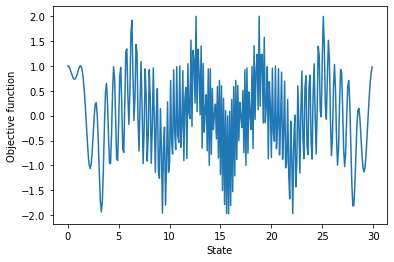

[18.8, 1.9938182298626619]
(6.299999999999999, 1.912344873493553)


In [48]:
class state():
    def __init__(self, node, value):
        self.node = node
        self.value = value  


class anneal:
    
    def __init__(self, initial, objective_function, schedule_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        self.schedule_function = schedule_function

    def random_move(self):
        '''return a random move, possible from the current_state'''
        all_moves = self.moves()
        next_move = np.random.choice(all_moves)
        return next_move, self.objective_function(next_move)
        
    
    def best_move(self):
        '''return the best move possible from the current_state'''
        all_moves = self.moves()
        obj_func = [self.objective(move) for move in all_moves]
        best = all_moves[max(zip(obj_func, range(len(obj_func))))[1]]
        return best, np.max(obj_func)
    
    def moves(self):
        
        possible_moves = [self.current_state.node + self.stepsize, self.current_state.node - self.stepsize]  
        return possible_moves
        
        
def hill_climb(problem, n_iter):
    
    Max = 0
    MaxVal = 0
    
    for k in range(n_iter):
        nextMove, nextValue = problem.best_move()
        print(nextMove, nextValue)
        if nextValue <= problem.current_state.value:
            Max = problem.current_state
            MaxVal = nextValue
        problem.current_state.node, problem.current_state.value = nextMove, nextValue
    
    print('reached n_iter')
    return Max
    
    

def example_function(x):
    return sin(x**2)+cos(x)**5

def schedule(time):
    '''some sort of mapping from time to temperature, to represent how we should be 
    "cooling off" - that is, accepting wacky solutions with lower and lower probability'''
    C = 20#
    p = 0.7#
    temperature = C/(time+1)**p
    
    return temperature

def simulated_annealing(problem, n_iter):
    
    current = problem.initial_state
    
    for t in range(n_iter):
        temperature = problem.schedule_function(t)
        nextMove, nextValue = problem.random_move()
        delta_obj = nextValue - current.value
        #print(t, problem.current_state.node, problem.current_state.value, nextMove, nextValue, delta_obj)
        if delta_obj > 0:
            # the proposed move is an improvement, so accept w.p. 1
            problem.current_state.node, problem.current_state.value = nextMove, nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = np.exp(delta_obj/temperature)
            #print(p_accept)
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                problem.current_state.node, problem.current_state.value = nextMove, nextValue

    return problem.current_state

stop = 30

Range = np.arange(start=0, stop=30, step=0.1)
fx = [example_function(xk) for xk in Range]
plt.plot(Range, fx)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

store = list(max(zip(fx, Range)))
store.reverse()

print(store)


initial = np.arange(start=0, stop=10, step=0.5)
out = []
for init in initial:
    initial_state = state(node=init, value=example_function(init))
    problem = anneal(initial=initial_state, objective_function=example_function, 
                            schedule_function=schedule, stepsize=0.2)
    temp = simulated_annealing(problem, n_iter=1000)
    out.append((temp.node, temp.value))

out.sort(key = lambda x:x[1])
print(out[-1])


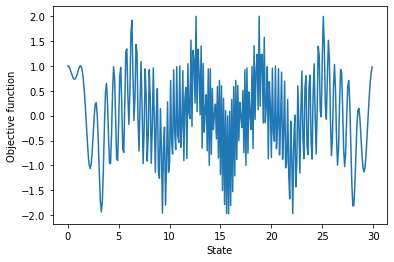

[18.8, 1.9938182298626619]
1.24535942082137285 1.003143408601437


In [47]:
import random

class Genetic():

    def __init__(self, function, initial = 4.4, runs = 10000):
        self.function = function
        self.initial = initial
        self.runs = runs
        self.curr_max = initial
        self.curr_dist = 0
    
    def run(self):
        
        if self.curr_max.is_integer():
            self.curr_max += 0.00001
            
        for i in range(self.runs):
            temp = self.mutate(self.curr_max)
            f_score = self.fitness_score(temp)
            
            if f_score > self.curr_dist:
                self.curr_dist = f_score
                self.curr_max = temp
                
        
    def fitness_score(self, number):
        return self.function(number)
        
    def mutate(self, number):
        binary = str(self.binmaker(float(number)))
        x = random.randint(-1, len(binary)+1) 
        
        while x < len(binary) and x >= 0 and binary[x] == '.':
            x = random.randint(-1, len(binary)+1)
         
        if x == -1:
            binary = '1' + binary
            
        temp = ''
        
        for i in range(len(binary)):
            if i == x:
                if binary[i] == '0':
                    temp += '1'
                else:
                    temp += '0'
            else:        
                temp += binary[i]
        
        return self.decmaker(temp)
    
    def decmaker(self, number):
        temp = str(number)
        if temp[0] == '.':
            temp = '0' + temp
            
        if '.' not in str(number):

            temp = temp[::-1]
            decimal = 0

            for i in range(len(temp)):
                decimal += int(temp[i]) * 2**i

            return decimal  

        else:
            x = 0
            first = ''

            while temp[x] != '.':
                first += temp[x]
                x += 1

            store = str(self.decmaker(int(first)))

            second = ''
            x += 1

            while x < len(temp):
                second += temp[x]
                x += 1

            temp = ''

            decimal = 0

            for i in range(len(second)):
                if second[i] == '1':
                    decimal += 0.5**(i+1)

            store += str(decimal)[1:]

            return store  
                
        
    def binmaker(self,number):
        final = ''
        temp = str(number)
        
        if temp[0] == '.':
            temp = '0' + temp
            
        if '.' not in str(number):
            while number != 0:
                number /= 2

                if number > int(number):
                    final += '1'
                else:
                    final += '0'

                number = int(number)

            return final[::-1]

        else:
            x = 0
            first = ''

            while temp[x] != '.':
                first += temp[x]
                x+=1

            store = self.binmaker(int(first))

            second = ''

            while x < len(temp):
                second += temp[x]
                x += 1

            second = float(second)
            temp = ''

            while second != 0:
                second *= 2

                if second >= 1:
                    second -= 1
                    temp += '1'
                else:
                    temp += '0'

            store += '.'
            store += temp

            return store
    
    

def example_function(x):
#     print("func:", x)
    x = float(x)
    return sin(x**2)+cos(x)**5

find = Genetic(function = example_function)    
find.run()

Range = np.arange(start=0, stop=30, step=0.1)
fx = [example_function(xk) for xk in Range]
plt.plot(Range, fx)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

store = list(max(zip(fx, Range)))
store.reverse()

print(store)
print(find.curr_max, find.curr_dist)

        


In [29]:
import csv 
import requests 
import xml.etree.ElementTree as ET 

def breakRange(String):
    one = ""
    two = ""
    
    x = 0
    
    for letter in String:
        x += 1
        
        if letter == '-':
            break
            
        one += letter
        
    for letter in String[x:]:
        two += letter
    
    return float(one), float(two)

def parseXML(xmlfile): 
  
    # create element tree object 
    tree = ET.parse(xmlfile) 
  
    # get root element 
    root = tree.getroot() 
    
    
    for child in root:
        if child.tag == 'alg':
            for grandchild in child:
                if grandchild.tag == 'item-reg':
                    for greatgrandchild in grandchild:
                        store = greatgrandchild.text
                        return breakRange(store)
  
    # create empty list for news items 
    newsitems = [] 

def main(): 
    # load rss from web to update existing xml file 
  
    # parse xml file 
    Range = parseXML('config-fair.xml') 
    
    jump = 10
    
    if isinstance(Range, tuple):
        distance = Range[1] - Range[0]
        
        jumps = distance/jump
        
        initial = [Range[0] + i*jumps for i in range(jump+1)]
            
        print(initial)
        
if __name__ == "__main__": 
    main() 

[0.001, 0.0109, 0.020800000000000003, 0.030700000000000005, 0.040600000000000004, 0.0505, 0.06040000000000001, 0.0703, 0.08020000000000001, 0.09010000000000001, 0.1]
